In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import os

LOADING DATA

In [7]:
load_path = "deeponet_antiderivative_aligned"
d = np.load(os.path.join(load_path, "antiderivative_aligned_train.npz"), allow_pickle=True)
X_train = (torch.tensor(d["X"][0], dtype = torch.float32), torch.tensor(d["X"][1], dtype = torch.float32))
y_train = torch.tensor(d["y"], dtype =torch.float32)
d = np.load(os.path.join(load_path, "antiderivative_aligned_test.npz"), allow_pickle=True)
X_test = (torch.tensor(d["X"][0], dtype = torch.float32), torch.tensor(d["X"][1], dtype =torch.float32))
y_test = torch.tensor(d["y"], dtype= torch.float32)

train_data = {"x_train": X_train, "u_train": y_train}
test_data = {"x_test": X_test, "u_test": y_test}

DEFINING PARAMETERS

In [32]:
m = y_train.shape[1]  # This is 100, the number of sensor points for each sample
dim_x = X_train[1].shape[1]  # This is 1, input dimension for trunk

branch_architecture = [m, 40, 40]  # Correct for the branch network
trunk_architecture = [dim_x, 40, 40]  # Correct for the trunk network

DEFINING ARCHITECTURE

In [30]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, activation=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(activation())

        for i in range(1, len(hidden_dims)):
            layers.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
            layers.append(activation())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# PyTorch version of the DeepONet class
class DeepONet(nn.Module):
    def __init__(self, layer_sizes_branch, layer_sizes_trunk):
        super(DeepONet, self).__init__()
        self.branch = MLP(layer_sizes_branch[0], layer_sizes_branch[1:], activation=nn.Tanh)
        self.trunk = MLP(layer_sizes_trunk[0], layer_sizes_trunk[1:], activation=nn.Tanh)
        self.b = nn.Parameter(torch.zeros(1, dtype=torch.float32))  # Bias term

    def forward(self, inputs):
        f, x = inputs  # Unpack the tuple
        F = self.branch(f)  # Output of the branch network
        X = self.trunk(x)   # Output of the trunk network
        u = torch.einsum('bi,ni->bn', F, X)  # Vectorized inner product
        u += self.b
        return u

# AntiDerivative class using PyTorch
class AntiDerivative:
    def __init__(self, net, train_data, test_data, log_path=None):
        self.net = net
        self.train_data = train_data
        self.test_data = test_data
        self.log_path = log_path

    def train_step(self, x_train, u_train, optimizer_B, optimizer_T, criterion):
        self.net.train()
        optimizer_B.zero_grad()
        optimizer_T.zero_grad()

        u_hat = self.net(x_train)  # Forward pass
        loss = criterion(u_hat, u_train)
        loss.backward()  # Backward pass

        optimizer_B.step()
        optimizer_T.step()

        return loss.item()

    def train(self, learning_rate=0.001, epochs=5000):
        # Setup optimizers
        optimizer_B = optim.Adam(self.net.branch.parameters(), lr=learning_rate)
        optimizer_T = optim.Adam(self.net.trunk.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()

        x_test = self.test_data["x_test"]
        u_test = self.test_data["u_test"]

        # Randomly select test ids for plotting
        test_idx = np.random.randint(0, u_test.shape[0], size=(9,))

        # Training loop
        for ep in range(epochs):
            x_train = self.train_data["x_train"]
            u_train = self.train_data["u_train"]
            loss = self.train_step(x_train, u_train, optimizer_B, optimizer_T, criterion)

            if ep % 1000 == 0:
                print(f"Epoch {ep}, Loss: {loss}")
                self.plot_predictions(test_idx, x_test, u_test, ep)

    def plot_predictions(self, test_idx, x_test, u_test, ep):
        self.net.eval()
        u_hat = self.net(x_test).detach().cpu().numpy()

        # Plotting setup
        plt_num_row = 3
        plt_num_col = 3
        fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(3 * plt_num_col, 3 * plt_num_row),
                                subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)

        for j in range(plt_num_col):
            for i in range(plt_num_row):
                I = test_idx[j * plt_num_row + i]
                axs[i][j].plot(u_hat[I, :], label=f"Predicted-#{I}")
                axs[i][j].plot(u_test[I, :], label=f"Ground Truth-#{I}")
                axs[i][j].legend()

        plot_path = os.path.join(self.log_path, "plots")
        if not os.path.exists(plot_path):
            os.makedirs(plot_path)

        plt.savefig(os.path.join(plot_path, f'contour_{ep}.png'))
        plt.close('all')

Epoch 0, Loss: 0.6828783750534058
Epoch 1000, Loss: 0.0004207689198665321
Epoch 2000, Loss: 0.00015110296953935176
Epoch 3000, Loss: 4.761983655043878e-05
Epoch 4000, Loss: 4.267991607775912e-05


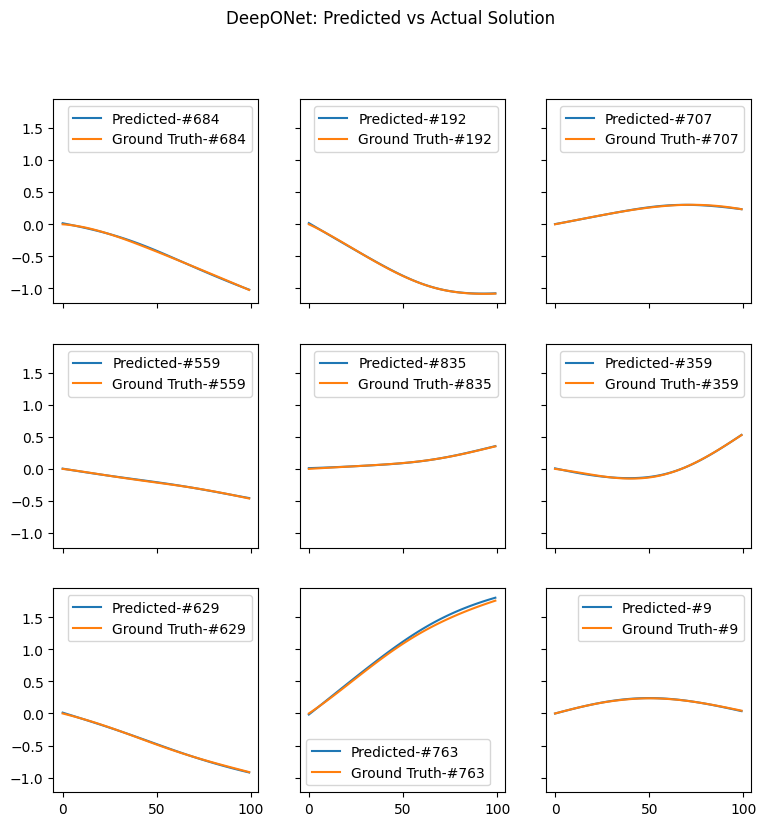

In [33]:
# Initialize DeepONet with corrected input shapes
deeponet = DeepONet(branch_architecture, trunk_architecture)

# Initialize the AntiDerivative model and begin training
model = AntiDerivative(deeponet, train_data, test_data, log_path=load_path)
model.train(learning_rate=0.001, epochs=5000)

# Function to plot the predicted vs actual data
def plot_solution_vs_data(model, test_data, num_samples=9, seed=0):
    np.random.seed(seed)
    x_test = test_data["x_test"]
    u_test = test_data["u_test"]

    u_hat = model.net(x_test).detach().cpu().numpy()

    test_idx = np.random.randint(0, u_test.shape[0], size=(num_samples,))
    plt_num_row = int(np.sqrt(num_samples))
    plt_num_col = int(np.ceil(num_samples / plt_num_row))

    fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(3 * plt_num_col, 3 * plt_num_row),
                            subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)

    for j in range(plt_num_col):
        for i in range(plt_num_row):
            I = test_idx[j * plt_num_row + i]
            axs[i][j].plot(u_hat[I, :], label=f"Predicted-#{I}")
            axs[i][j].plot(u_test[I, :], label=f"Ground Truth-#{I}")
            axs[i][j].legend()

    plt.suptitle("DeepONet: Predicted vs Actual Solution")
    plt.show()

# Call this function after training
plot_solution_vs_data(model, test_data, seed=0)